# Mercari Price Prediction Exploratory Data Analysis (EDA)

### This is an initial Explanatory Data Analysis for the Mercari Price Suggestion Challenge from Kaggle.com. The competition is hosted by Mercari, the biggest Japanese community-powered shopping app with the main objective of predicting accurate prices of products that Mercari should suggest to its sellers, given each item's name, item description, conidtion, category name, brand, and shipping code. 

### Below we will start by importing the necessary libraries at Python's disposal to perform some visual and detailed analysis of the data before moving onto the machine learning portion of the project:

In [1]:
import scipy as sp
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#Term frequency vectorizer
from sklearn.model_selection import train_test_split
import re
from scipy import stats

## Initial Look:

#### Here we will look at the data overview, tables, and some simple graphs of the target variable and transformations before we delve into each individual category and its relation to the target variable (price).

In [2]:
train = pd.read_csv("train.tsv", sep='\t', header=0)
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


#### Already the data appears to have some numerical values, but also has string based features that we will have to transform. The price feature will be our target variable.

In [3]:
test = pd.read_csv("test.tsv", sep='\t', header=0)
test.head()

,test_id,name,item_condition_id,category_name,brand_name,shipping,item_description
0,0,"Breast cancer ""I fight like a girl"" ring",1,Women/Jewelry/Rings,NaN,1,Size 7
1,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers",1,Other/Office supplies/Shipping Supplies,NaN,1,"25 pcs NEW 7.5""x12"" Kraft Bubble Mailers Lined..."
2,2,Coach bag,1,Vintage & Collectibles/Bags and Purses/Handbag,Coach,1,Brand new coach bag. Bought for [rm] at a Coac...
3,3,Floral Kimono,2,Women/Sweaters/Cardigan,NaN,0,-floral kimono -never worn -lightweight and pe...
4,4,Life after Death,3,Other/Books/Religion & Spirituality,NaN,1,Rediscovering life after the loss of a loved o...


In [4]:
train.describe()

,train_id,item_condition_id,price,shipping
count,1.482535e+06,1.482535e+06,1.482535e+06,1.482535e+06
mean,7.412670e+05,1.907380e+00,2.673752e+01,4.472744e-01
std,4.279711e+05,9.031586e-01,3.858607e+01,4.972124e-01
min,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,3.706335e+05,1.000000e+00,1.000000e+01,0.000000e+00
50%,7.412670e+05,2.000000e+00,1.700000e+01,0.000000e+00
75%,1.111900e+06,3.000000e+00,2.900000e+01,1.000000e+00
max,1.482534e+06,5.000000e+00,2.009000e+03,1.000000e+00


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
train_id             1482535 non-null int64
name                 1482535 non-null object
item_condition_id    1482535 non-null int64
category_name        1476208 non-null object
brand_name           849853 non-null object
price                1482535 non-null float64
shipping             1482535 non-null int64
item_description     1482531 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


In [6]:
train.shape

(1482535, 8)

In [7]:
train.dtypes

train_id               int64
name                  object
item_condition_id      int64
category_name         object
brand_name            object
price                float64
shipping               int64
item_description      object
dtype: object

In [8]:
train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


#### We have a couple of string based features (*name*, *category_name*, *brand_name*, and *item_description*) that can later be used to combine or separate into a text classification using term frequency vectorization. Stop words will have to be removed for the analysis to work and top features will have to be gleaned from the data.

#### *item_condition_id* and *shipping* could potentially be used as binary values that further help reach accurate price predictions.


#### We will be combining the train and test sets to conduct data cleaning measures at equal rate. A mask with train_rows will be created to separate the data to their respective train and test sets after data cleaning is completed.

In [9]:
# remove rows with empty descriptions
train = train[~train['item_description'].isnull()]
test = test[~test['item_description'].isnull()]

data = pd.concat([train, test], 0)
train_rows = train.shape[0]
print(train_rows)

1482531


In [10]:
train.item_description

0                                         No description yet
1          This keyboard is in great condition and works ...
2          Adorable top with a hint of lace and a key hol...
3          New with tags. Leather horses. Retail for [rm]...
4                  Complete with certificate of authenticity
5          Banana republic bottoms, Candies skirt with ma...
6          Size small but straps slightly shortened to fi...
7          You get three pairs of Sophie cheer shorts siz...
8           Girls Size small Plus green. Three shorts total.
9          I realized his pants are on backwards after th...
10              0.25 oz Full size is 1oz for [rm] in Sephora
11         (5) new vs pink body mists (2.5 oz each) Fresh...
12                                       Xl, great condition
13                                        No description yet
14         Authentic. Suede fringe boots. Great condition...
15         Brand new. Deluxe travel size products. Contai...
16         2 glitter eye

#### The item_description section will need to be cleaed up as there are a lot of punctuations, symbols (✨), and capital letters that would otherwise interfere with the learning algorithms.

## I. Initial Look (Target Variable): Price graphs

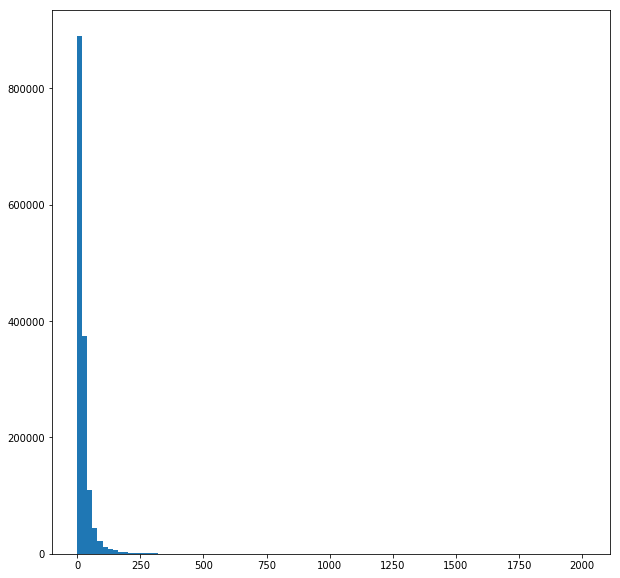

In [11]:
plt.figure(figsize=(10,10))
plt.hist(train['price'], bins = 100)
plt.show()

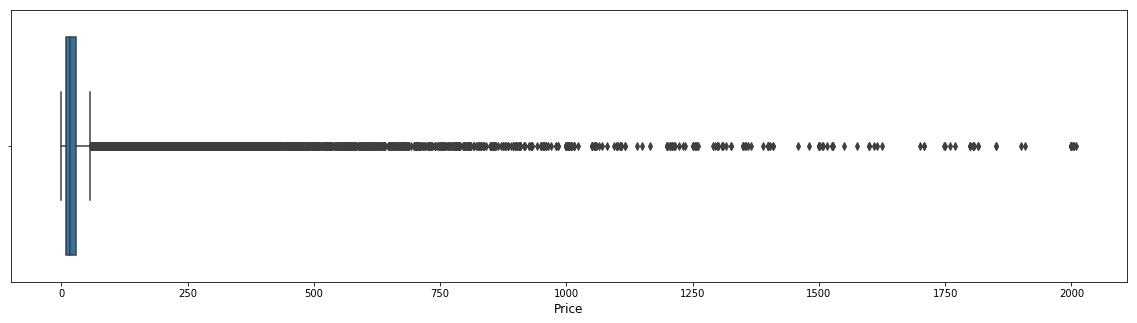

In [12]:
plt.figure(figsize= (20,5)) 
sns.boxplot(train.price)
plt.xlabel("Price", fontsize='large')
plt.show()

#### The price value is exponentially distributed and this target variable data will not play well with others. Therefore we will normalize the price category by taking the log of the data to try an assume a more Gaussian distribution:

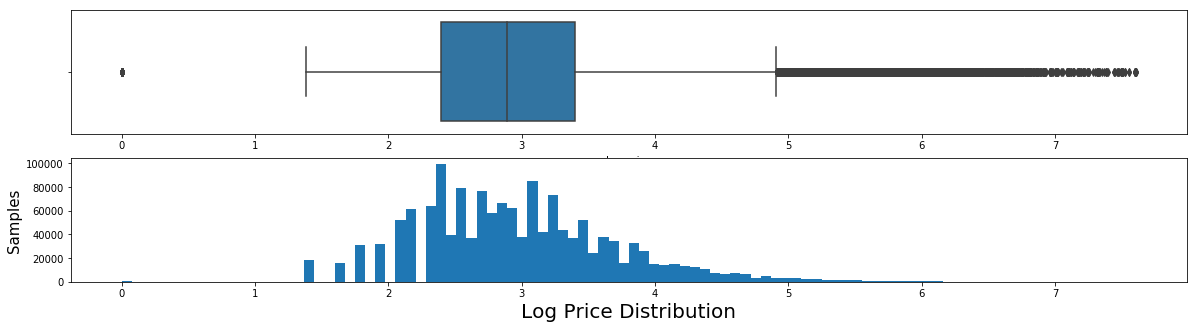

In [13]:
train['log_price'] = np.log(train.price + 1)
fig, ax = plt.subplots(2, 1, figsize = (20, 5))
sns.boxplot(train.log_price, ax = ax[0])
ax[1].hist(train.log_price, bins = 100)
#ax[1].set_title("Log Price Distribution", fontsize = 20)
ax[1].set_xlabel("Log Price Distribution", fontsize = 20)
ax[1].set_ylabel("Samples", fontsize = 15)
plt.show()

#### Taking the log (+1 to avoid 0 or negative values) has allowed the target variable to assume a more Gaussian distribution which will be more optimal for modeling. 

####  Median Log Price comes out to 2.890472e+00, while mean is close by at 2.979060e+00

#### However, this data also assumes to have some outliers and we are going to do a little pruning of outlier data.

In [14]:
q = train['log_price'].quantile(0.975)
train = train[train['log_price'] < q]
train = train[train['log_price'] > 0]

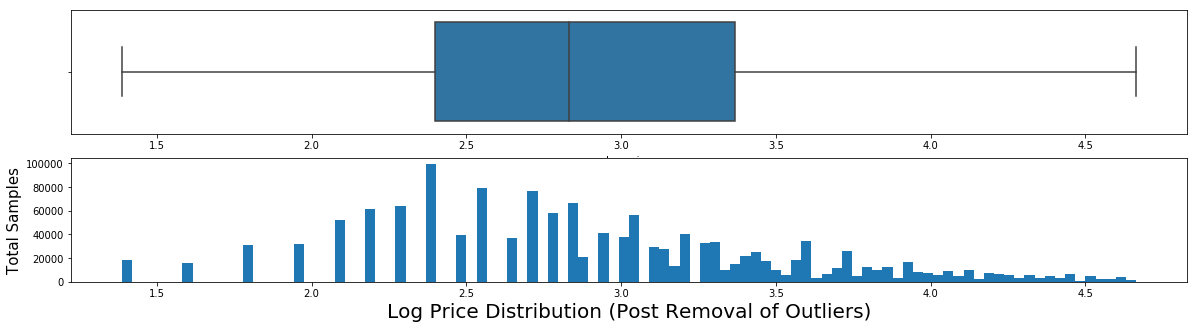

In [15]:
fig, ax = plt.subplots(2, 1, figsize = (20,5))
sns.boxplot(train.log_price, ax = ax[0])
ax[1].hist(train.log_price, bins = 100)
#ax[1].set_title("Log Price Distribution", fontsize = 20)
ax[1].set_xlabel("Log Price Distribution (Post Removal of Outliers)", fontsize = 20)
ax[1].set_ylabel("Total Samples", fontsize = 15)
plt.show()

There still appears to be a lot of 0 values within the price. let us remove those are well to make sure that all outliers and 0 values (which would make no sense) to be removed).

In [16]:
(1482531-len(train))/1482531

0.027162332524581275

In [17]:
1482531-len(train)

40269

####  essentially pruned out 2.72% of the dataset where our log price did not fit within the 97.5% of our normal distrbution. This resulted in close to 40k rows of data being lost for the sake of model integrity.

## II. Shipping

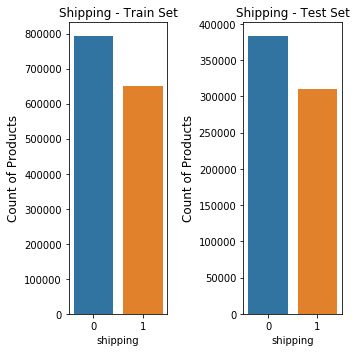

In [18]:
_ = plt.figure(figsize=(5,5))
_ = plt.subplot(1,2,1)
_ = sns.countplot(train['shipping'])
_ = plt.ylabel("Count of Products", fontsize='large')
_ = plt.title('Shipping - Train Set')


_ = plt.subplot(1,2,2)
_ = sns.countplot(test['shipping'])
_ = plt.ylabel("Count of Products", fontsize='large')
_ = plt.title('Shipping - Test Set')

plt.tight_layout()
plt.show()

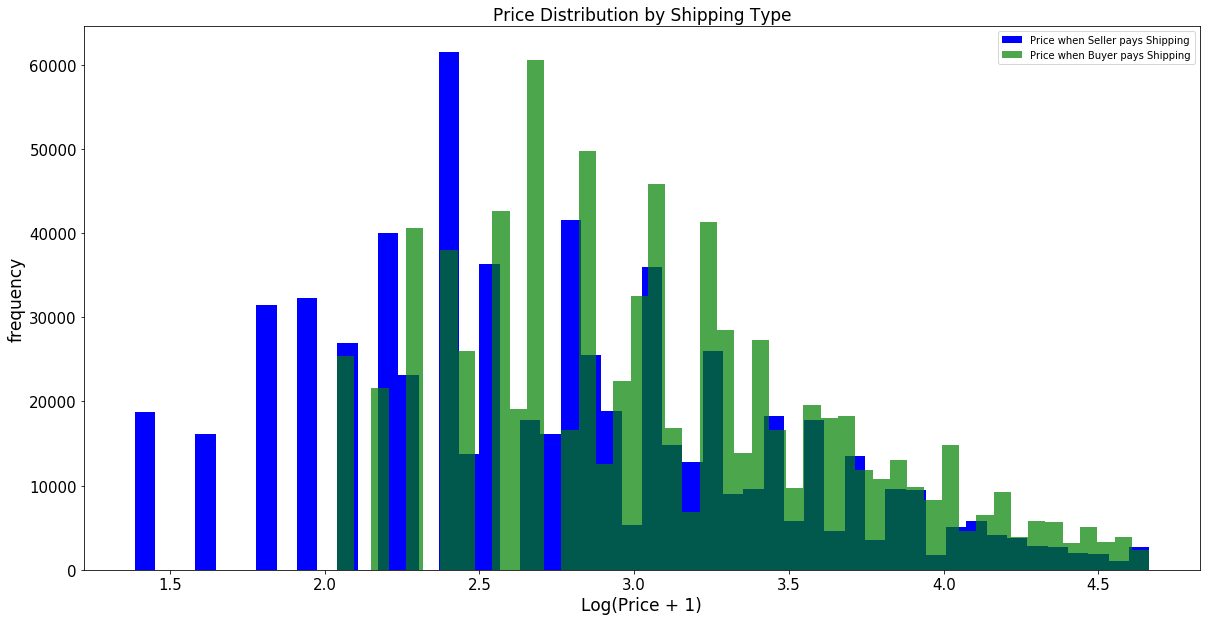

In [19]:
shipping_seller_price = train.loc[train.shipping==1, 'price']
shipping_buyer_price = train.loc[train.shipping==0, 'price']

fig, ax = plt.subplots(figsize=(20,10))
ax.hist(np.log(shipping_seller_price+1), color='blue', alpha=1.0, bins=50,
       label='Price when Seller pays Shipping')
ax.hist(np.log(shipping_buyer_price+1), color='green', alpha=0.7, bins=50,
       label='Price when Buyer pays Shipping')
ax.set(title='Histogram Comparison', ylabel='% of Dataset in Bin')
plt.xlabel('Log(Price + 1)', fontsize=17)
plt.ylabel('frequency', fontsize=17)
plt.title('Price Distribution by Shipping Type', fontsize=17)
plt.legend()
plt.tick_params(labelsize=15)

plt.show()



#### Semi expected as the target price variable is higher for when the customer (buyer) covers shipping vs when the seller pays/ covers shipping. The inflated price value for when the customer covers shipping costs makes sense.

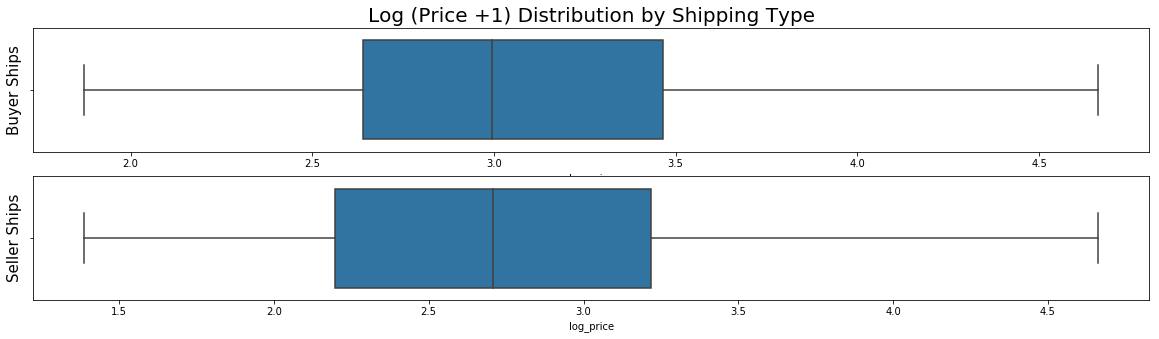

In [20]:
buyer_ships = train[train['shipping'] == 0]
seller_ships = train[train['shipping'] == 1]
fig, ax = plt.subplots(2, 1, figsize = (20,5))
sns.boxplot(buyer_ships.log_price, ax = ax[0])
sns.boxplot(seller_ships.log_price, ax = ax[1])
ax[0].set_title("Log (Price +1) Distribution by Shipping Type", fontsize = 20)
ax[0].set_ylabel("Buyer Ships", fontsize = 15)
ax[1].set_ylabel("Seller Ships", fontsize = 15)

plt.show()

#### This visualization shows legitimate hard differences in log price between the shipping types. We will conduct a t-test to prove significance

In [21]:
t, p = sp.stats.ttest_ind(buyer_ships.log_price,seller_ships.log_price)
print("T-Value for shipping x log_price = " + str(t))
#multiplying by 2 since it is a two tailed T-test
print("P-Value for shipping x log_price = " + str(float(2*p)))

T-Value for shipping x log_price = 306.810009363
P-Value for shipping x log_price = 0.0


#### Shipping indeed is a significant determining factor in  log price as the shipping feature delineates a quite large t-value and a p-value less than 0.05 (signifiying significance) between the log prices of seller-shipped and buyer-shipped items. 

## III. Item Condition

#### Not very visible in terms of difference between item condition when plotting against log_price, let's see what plotting for actual price will do:

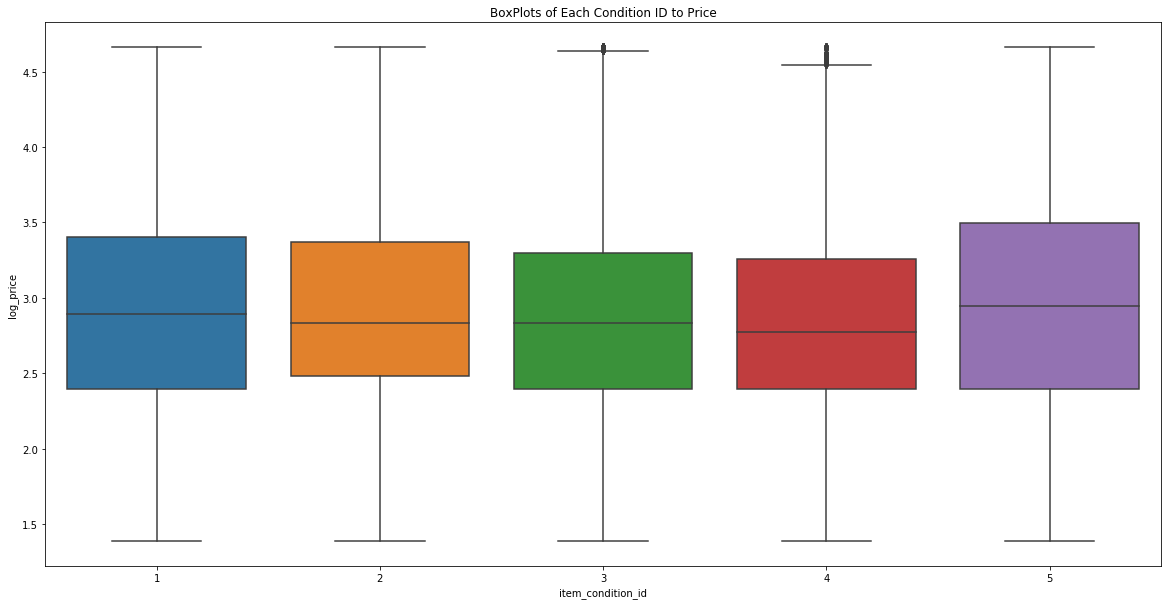

In [22]:
plt.figure(figsize=(20,10))
sns.boxplot(x = 'item_condition_id', y = 'log_price', data = train)
plt.title('BoxPlots of Each Condition ID to Price')
plt.show()

#### Upon first glance of these charts the item conditions visually appear to show no significant difference. It seems like item conditions 5 to 1 are both higher than the middle tier item conditions (2-4). This is something we should look more into. However, an ANOVA test could prove each item condition's log price to hold significant differences:

In [23]:
item_condition1 = train[train['item_condition_id'] == 1]
item_condition2 = train[train['item_condition_id'] == 2]
item_condition3 = train[train['item_condition_id'] == 3]
item_condition4 = train[train['item_condition_id'] == 4]
item_condition5 = train[train['item_condition_id'] == 5]

In [24]:
import scipy.stats as stats

item_condition1 = train[train['item_condition_id'] == 1]
item_condition2 = train[train['item_condition_id'] == 2]
item_condition3 = train[train['item_condition_id'] == 3]
item_condition4 = train[train['item_condition_id'] == 4]
item_condition5 = train[train['item_condition_id'] == 5]
anova_score = stats.f_oneway(item_condition1.log_price, item_condition2.log_price,
                             item_condition3.log_price, item_condition4.log_price, item_condition5.log_price)
print("Anova Score: ", anova_score)


Anova Score:  F_onewayResult(statistic=186.07522566316254, pvalue=9.7827918615853352e-160)


#### The high F-value shows a case where the variability of group means is large relative to the within group variability. In order to reject the null hypothesis that the group means are equal, we need a high F-value.

## III. Categories

In [25]:
train['category_name'].head()

0                                    Men/Tops/T-shirts
1    Electronics/Computers & Tablets/Components & P...
2                          Women/Tops & Blouses/Blouse
3                   Home/Home Décor/Home Décor Accents
4                              Women/Jewelry/Necklaces
Name: category_name, dtype: object

In [26]:
print('unique categories: ', train['category_name'].nunique())
print('unique products: ', train['name'].nunique())

unique categories:  1286
unique products:  1192442


#### Womens, Beauty, and Electronics come at the top ten frequency of products for raw categories. The dataset provide valuable information about the primary kinds of customer community that Mercari may most likely have. There is not gender designation or order details, but there seems to be a large frequency of Women's beauty products and clothing. Let us see the price breakdowns of products:

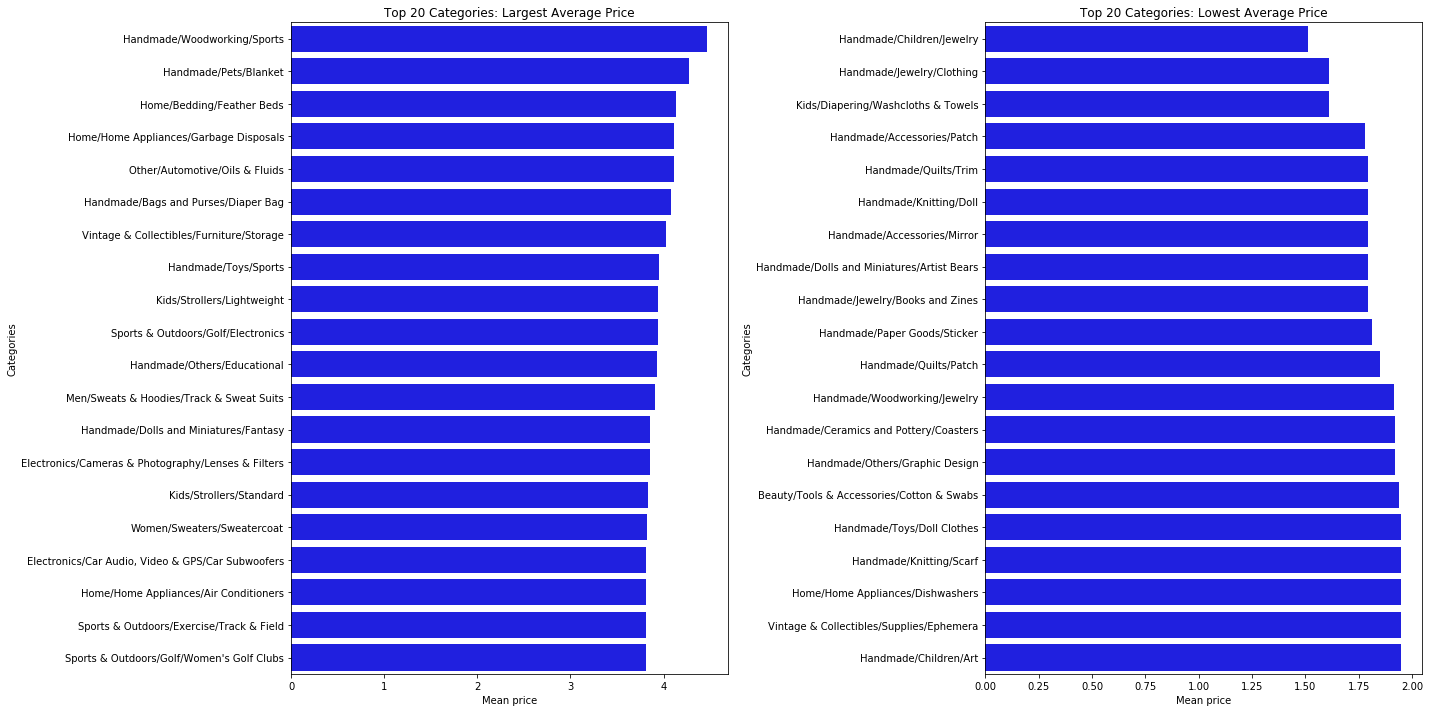

In [27]:
categories = train.groupby(train.category_name)
price = pd.DataFrame(categories['log_price'].mean())
high_price = price.sort_values(by='log_price', ascending = False).head(20)
high_price.reset_index(level=0, inplace=True)
low_price = price.sort_values(by='log_price', ascending = True).head(20)
low_price.reset_index(level=0, inplace=True)

plt.figure(figsize=(20,10))
_ = plt.subplot(1,2,1)
_ = sns.barplot(x = 'log_price', y = 'category_name', data = high_price, orient = 'h', color='blue')
_ = plt.title('Top 20 Categories: Largest Average Price')
_ = plt.ylabel('Categories')
_ = plt.xlabel('Mean price')


_ = plt.subplot(1,2,2)
_ = sns.barplot(x = 'log_price', y = 'category_name', data = low_price, orient = 'h', color='blue')
_ = plt.title('Top 20 Categories: Lowest Average Price')
_ = plt.ylabel('Categories')
_ = plt.xlabel('Mean price')

plt.tight_layout()
plt.show()

#### We see that the breakdown of aggregated categories can indeed be more granular. We can try to break the "category_name" field into three distinct columns, but for text based vectorization, three distinct columns with multiple combinations may not be ideal and may cause overfitting of data. For this case, we will take the primary category and secondary category to see if granularity in category name would be important or if having the whole category as one name is more optimal:

In [28]:
train['primary_cat'] = train.category_name.str.extract('([^/]+)/[^/]+/[^/]+')
train['secondary_cat'] = train.category_name.str.extract('[^/]+/([^/]+/[^/]+)')

c:\users\kj.park\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  """Entry point for launching an IPython kernel.
c:\users\kj.park\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
  


In [29]:
print('unique primary categories: \n',train['primary_cat'].nunique())
print('unique secondary categories: \n',train['secondary_cat'].nunique())

unique primary categories: 
 10
unique secondary categories: 
 1197


#### There are 10 main categories (basically like aisles), 1197 secondary categories (aisle contents). We could split this even further, but in doing so, we would most likely create an issue with dimensionality.

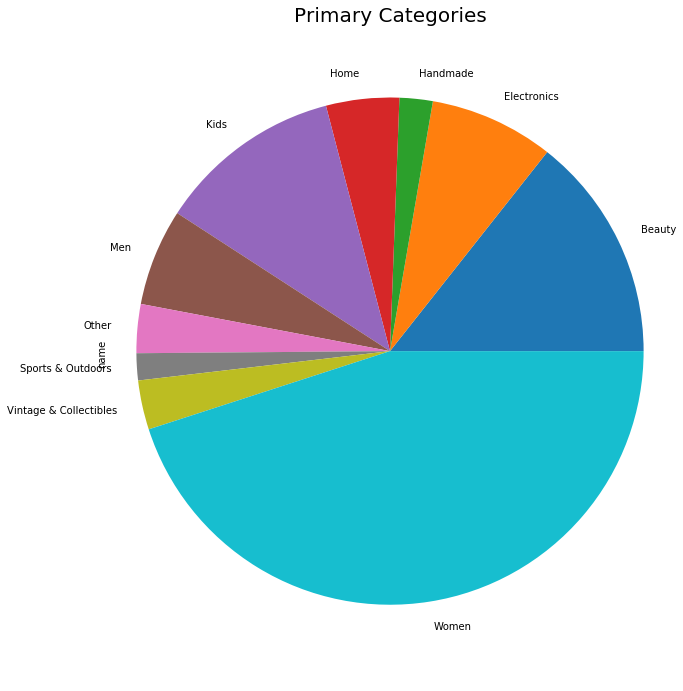

In [30]:
plt.figure(figsize = (10,12))
train.name.groupby(train.primary_cat).count().plot(kind = 'pie')
plt.title ('Primary Categories', fontsize = 20)
plt.axis('equal')
plt.show()

#### Women's product counts make up the most Mercari's supply in primary category, while Beauty products are also numerous.

#### The plot below will explore the relation of log price to the primary categories:

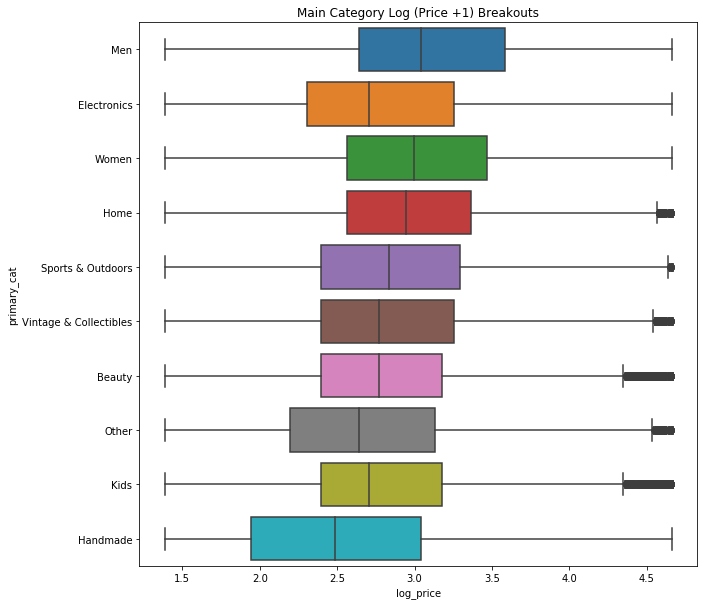

In [31]:
plt.figure(figsize = (10,10))
plt.title('Main Category Log (Price +1) Breakouts')
plt.xlabel("Log (Price +1")
plt.ylabel("Primary Categories")
ax = sns.boxplot(x = 'log_price' , y ="primary_cat", data=train, orient="h")
plt.show()

#### Seems we have some outlier data in Home, vintage and Collectibles, Beauty, and Kids. These most likely are high priced items that may be from high priced brands, which will most likely have to be paired to the text corpus in relation to log (price +1). 

In [32]:
categories_secondary = train.groupby(train.secondary_cat)
price = pd.DataFrame(categories_secondary['log_price'].mean())
high_price = price.sort_values(by='log_price', ascending = False).head(20)
high_price.reset_index(level=0, inplace=True)
low_price = price.sort_values(by='log_price', ascending = True).head(20)
low_price.reset_index(level=0, inplace=True)



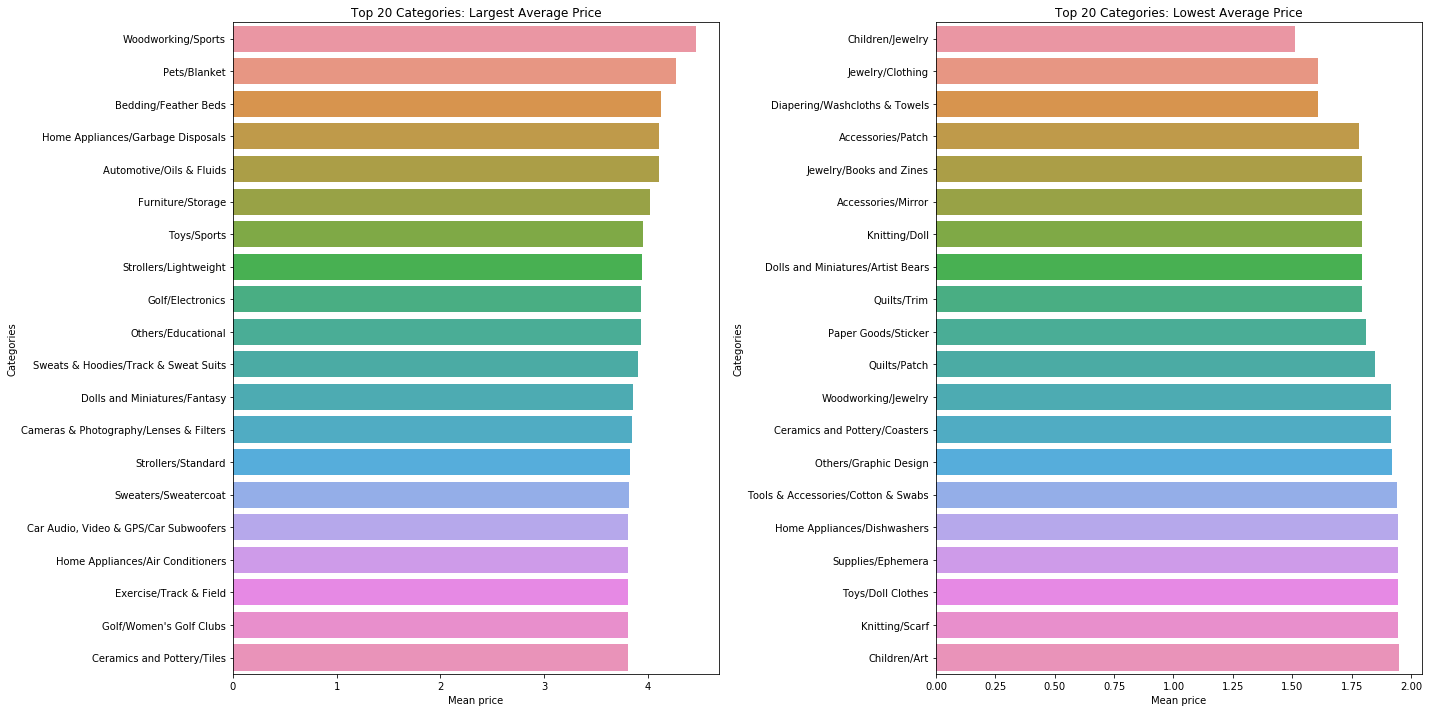

In [33]:
plt.figure(figsize=(20,10))
_ = plt.subplot(1,2,1)
_ = sns.barplot(x = 'log_price', y = 'secondary_cat', data = high_price, orient = 'h')
_ = plt.title('Top 20 Categories: Largest Average Price')
_ = plt.ylabel('Categories')
_ = plt.xlabel('Mean price')


_ = plt.subplot(1,2,2)
_ = sns.barplot(x = 'log_price', y = 'secondary_cat', data = low_price, orient = 'h')
_ = plt.title('Top 20 Categories: Lowest Average Price')
_ = plt.ylabel('Categories')
_ = plt.xlabel('Mean price')

plt.tight_layout()
plt.show()

#### From this point we wil be tokenizing certain features at an individual level to see if there is a case for using the categories in the machine learning algorithm. We will be checking on the individual features one by on in relation to the target price variable to determine their efficacy for future use in the machine learning algorithm. 

#### The words with be tokenized using a Lemmatizer that will remove any suffixes and any additional verbiage to create root word tokens for the feature corpus

In [34]:
from nltk import word_tokenize          
from nltk.stem import WordNetLemmatizer 
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
import nltk
nltk.download('wordnet')
class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, articles):
        return [self.wnl.lemmatize(t) for t in word_tokenize(articles)]

tfidf = TfidfVectorizer(tokenizer=LemmaTokenizer(),
                                strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                max_df = .6,
                                min_df = 3,
                                max_features=1000,
                                ngram_range=(1, 2))

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kj.park\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [35]:
train = train.apply(lambda x: x.astype(str).str.lower())
text_features = ['name', 'brand_name', 'category_name', 'primary_cat', 'secondary_cat', 'item_description']
for t in text_features:
    train[t].replace(regex=True,inplace=True,to_replace=r'\W',value=r' ')
    
primary_cat = train['primary_cat'].values
secondary_cat = train['secondary_cat'].values


In [36]:
primary_cat = tfidf.fit_transform(primary_cat)

In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(primary_cat, train.log_price, test_size=0.4, random_state=42)

In [38]:
lm = LinearRegression()
lm.fit(X_train, y_train)
print("R-Squared: ", (lm.score(X_test, y_test)))

R-Squared:  0.0377037814386


In [39]:
secondary_cat = tfidf.fit_transform(secondary_cat)

In [40]:
X_train, X_test, y_train, y_test = train_test_split(secondary_cat, train.log_price, test_size=0.4, random_state=42)
lm = LinearRegression()
lm.fit(X_train, y_train)
print("R-Squared: ", (lm.score(X_test, y_test)))

R-Squared:  0.210313598033


#### Once again, like shipping, the $R^{2}$ value is low, but the features are statistically significant. Primary Category did not score as high as the Secondary Category. Just for good measure, we will also look at category_name as a whole to see if the granularity created by the tfidf vectorizer leads to a more robust train set for the log price predictions for the $R^{2}$:

In [41]:
category_name = train['category_name'].values
category_name = tfidf.fit_transform(category_name)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(category_name, train.log_price, test_size=0.4, random_state=42)
lm = LinearRegression()
lm.fit(X_train, y_train)
print("R-Squared: ", (lm.score(X_test, y_test)))

R-Squared:  0.211423913678


#### There is definitely an improvement in the $R^{2}$ by leaving the main_category as is before term frequency x inverse document frequency vectorization. Therefore, we shall keep the category_name field for the corpus during the Machine learning portion of this project

## III. Brand Names

#### Text vectorization will take into consideration unique values. By removing spaces and adding pre-fix "brand_" to the text values of brand names, we can use the unique values to help create importance around the brand before adding it to the item description for the vectorizer.

In [43]:
train.brand_name.value_counts()

nan                    623693
pink                    53436
nike                    52823
victoria s secret       47650
lularoe                 30667
forever 21              15174
nintendo                14105
lululemon               13839
apple                   13588
american eagle          13237
sephora                 12046
rae dunn                11936
michael kors            11671
bath   body works       10306
disney                  10292
coach                    9934
adidas                   9228
funko                    8999
under armour             8440
old navy                 7558
sony                     7529
hollister                6941
carter s                 6373
urban decay              6175
the north face           6060
independent              5849
too faced                5759
brandy melville          5661
xbox                     5433
mac                      5258
                        ...  
red kap                     1
caruso                      1
tribest   

In [44]:
train['brand_name'] = train['brand_name'].replace([np.nan,'nan'], 'none', regex=True)
test['brand_name'] = test['brand_name'].replace([np.nan,'nan'], 'none', regex=True)

In [45]:
train['brand_name'] = train['brand_name'].str.replace('\s+', '')  # in case there are multiple white spaces
train['brand_name'] = 'brand_' + train['brand_name'].astype(str)
test['brand_name'] = test['brand_name'].str.replace('\s+', '')  # in case there are multiple white spaces
test['brand_name'] = 'brand_' + test['brand_name'].astype(str)

In [46]:
brand_name = train['brand_name'].values
brand_name = tfidf.fit_transform(brand_name)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(brand_name, train.log_price, test_size=0.4, random_state=42)
lm = LinearRegression()
lm.fit(X_train, y_train)
print("R-Squared: ", (lm.score(X_test, y_test)))

R-Squared:  0.197810342558


#### brand_name on its own scored higher than primary category, but is only 19.78%

## IV. Item Description

In [48]:
item_desc = train['item_description'].values

In [49]:
len(item_desc)

1442262

In [50]:
import nltk
import string
import os
from sklearn.linear_model import Ridge
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

estimators = [("tf_idf", TfidfVectorizer(max_features = 5000, lowercase=True)), 
              ("ridge", Ridge())]
model = Pipeline(estimators)
model.fit(item_desc, train['log_price'])


params = {"ridge__alpha":[0.1, 0.3, 0.5, 1, 3], #regularization param
          "tf_idf__max_df": [0.7,0.8],
          "tf_idf__ngram_range": [(1,1), (1,2)], #1-grams or 2-grams
          "tf_idf__stop_words": [None, "english"]#use stopwords or don't
         }



In [51]:
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(estimator=model, param_grid = params, scoring = "neg_mean_squared_error" , verbose=600)
grid.fit(item_desc, train['log_price'])

Fitting 3 folds for each of 40 candidates, totalling 120 fits
[CV] ridge__alpha=0.1, tf_idf__max_df=0.7, tf_idf__ngram_range=(1, 1), tf_idf__stop_words=None 
[CV]  ridge__alpha=0.1, tf_idf__max_df=0.7, tf_idf__ngram_range=(1, 1), tf_idf__stop_words=None, score=-0.31106475683876483, total= 1.9min
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.6min remaining:    0.0s
[CV] ridge__alpha=0.1, tf_idf__max_df=0.7, tf_idf__ngram_range=(1, 1), tf_idf__stop_words=None 
[CV]  ridge__alpha=0.1, tf_idf__max_df=0.7, tf_idf__ngram_range=(1, 1), tf_idf__stop_words=None, score=-0.31188438297021204, total= 1.9min
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.0min remaining:    0.0s
[CV] ridge__alpha=0.1, tf_idf__max_df=0.7, tf_idf__ngram_range=(1, 1), tf_idf__stop_words=None 
[CV]  ridge__alpha=0.1, tf_idf__max_df=0.7, tf_idf__ngram_range=(1, 1), tf_idf__stop_words=None, score=-0.31101186776046214, total= 2.1min
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  7.9min remaining:  

[CV]  ridge__alpha=0.3, tf_idf__max_df=0.7, tf_idf__ngram_range=(1, 1), tf_idf__stop_words=None, score=-0.31099797780068716, total= 1.5min
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed: 83.8min remaining:    0.0s
[CV] ridge__alpha=0.3, tf_idf__max_df=0.7, tf_idf__ngram_range=(1, 1), tf_idf__stop_words=english 
[CV]  ridge__alpha=0.3, tf_idf__max_df=0.7, tf_idf__ngram_range=(1, 1), tf_idf__stop_words=english, score=-0.31197765224400054, total= 1.5min
[Parallel(n_jobs=1)]: Done  28 out of  28 | elapsed: 86.0min remaining:    0.0s
[CV] ridge__alpha=0.3, tf_idf__max_df=0.7, tf_idf__ngram_range=(1, 1), tf_idf__stop_words=english 
[CV]  ridge__alpha=0.3, tf_idf__max_df=0.7, tf_idf__ngram_range=(1, 1), tf_idf__stop_words=english, score=-0.31285825353129737, total= 1.4min
[Parallel(n_jobs=1)]: Done  29 out of  29 | elapsed: 88.0min remaining:    0.0s
[CV] ridge__alpha=0.3, tf_idf__max_df=0.7, tf_idf__ngram_range=(1, 1), tf_idf__stop_words=english 
[CV]  ridge__alpha=0.3, tf_idf__max_df=0

[CV]  ridge__alpha=0.5, tf_idf__max_df=0.7, tf_idf__ngram_range=(1, 1), tf_idf__stop_words=english, score=-0.31284527684433594, total= 1.3min
[Parallel(n_jobs=1)]: Done  53 out of  53 | elapsed: 173.4min remaining:    0.0s
[CV] ridge__alpha=0.5, tf_idf__max_df=0.7, tf_idf__ngram_range=(1, 1), tf_idf__stop_words=english 
[CV]  ridge__alpha=0.5, tf_idf__max_df=0.7, tf_idf__ngram_range=(1, 1), tf_idf__stop_words=english, score=-0.31206583828193857, total= 1.5min
[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed: 175.5min remaining:    0.0s
[CV] ridge__alpha=0.5, tf_idf__max_df=0.7, tf_idf__ngram_range=(1, 2), tf_idf__stop_words=None 
[CV]  ridge__alpha=0.5, tf_idf__max_df=0.7, tf_idf__ngram_range=(1, 2), tf_idf__stop_words=None, score=-0.31273383477027883, total= 3.1min
[Parallel(n_jobs=1)]: Done  55 out of  55 | elapsed: 179.9min remaining:    0.0s
[CV] ridge__alpha=0.5, tf_idf__max_df=0.7, tf_idf__ngram_range=(1, 2), tf_idf__stop_words=None 
[CV]  ridge__alpha=0.5, tf_idf__max_df=0.7,

[CV]  ridge__alpha=1, tf_idf__max_df=0.7, tf_idf__ngram_range=(1, 2), tf_idf__stop_words=None, score=-0.3127079218220837, total= 3.0min
[Parallel(n_jobs=1)]: Done  79 out of  79 | elapsed: 267.1min remaining:    0.0s
[CV] ridge__alpha=1, tf_idf__max_df=0.7, tf_idf__ngram_range=(1, 2), tf_idf__stop_words=None 
[CV]  ridge__alpha=1, tf_idf__max_df=0.7, tf_idf__ngram_range=(1, 2), tf_idf__stop_words=None, score=-0.31353869796551226, total= 2.2min
[Parallel(n_jobs=1)]: Done  80 out of  80 | elapsed: 270.2min remaining:    0.0s
[CV] ridge__alpha=1, tf_idf__max_df=0.7, tf_idf__ngram_range=(1, 2), tf_idf__stop_words=None 
[CV]  ridge__alpha=1, tf_idf__max_df=0.7, tf_idf__ngram_range=(1, 2), tf_idf__stop_words=None, score=-0.3125896529302419, total= 2.2min
[Parallel(n_jobs=1)]: Done  81 out of  81 | elapsed: 273.2min remaining:    0.0s
[CV] ridge__alpha=1, tf_idf__max_df=0.7, tf_idf__ngram_range=(1, 2), tf_idf__stop_words=english 
[CV]  ridge__alpha=1, tf_idf__max_df=0.7, tf_idf__ngram_range=(

[CV]  ridge__alpha=3, tf_idf__max_df=0.7, tf_idf__ngram_range=(1, 2), tf_idf__stop_words=english, score=-0.3113196416573777, total= 1.8min
[Parallel(n_jobs=1)]: Done 106 out of 106 | elapsed: 333.2min remaining:    0.0s
[CV] ridge__alpha=3, tf_idf__max_df=0.7, tf_idf__ngram_range=(1, 2), tf_idf__stop_words=english 
[CV]  ridge__alpha=3, tf_idf__max_df=0.7, tf_idf__ngram_range=(1, 2), tf_idf__stop_words=english, score=-0.31195563603010684, total= 1.9min
[Parallel(n_jobs=1)]: Done 107 out of 107 | elapsed: 335.9min remaining:    0.0s
[CV] ridge__alpha=3, tf_idf__max_df=0.7, tf_idf__ngram_range=(1, 2), tf_idf__stop_words=english 
[CV]  ridge__alpha=3, tf_idf__max_df=0.7, tf_idf__ngram_range=(1, 2), tf_idf__stop_words=english, score=-0.3110855322229897, total= 1.8min
[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed: 338.4min remaining:    0.0s
[CV] ridge__alpha=3, tf_idf__max_df=0.8, tf_idf__ngram_range=(1, 1), tf_idf__stop_words=None 
[CV]  ridge__alpha=3, tf_idf__max_df=0.8, tf_idf__n

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('tf_idf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=5000, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
...it_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'ridge__alpha': [0.1, 0.3, 0.5, 1, 3], 'tf_idf__max_df': [0.7, 0.8], 'tf_idf__ngram_range': [(1, 1), (1, 2)], 'tf_idf__stop_words': [None, 'english']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=600)

In [52]:
grid.best_params_

{'ridge__alpha': 3,
 'tf_idf__max_df': 0.8,
 'tf_idf__ngram_range': (1, 1),
 'tf_idf__stop_words': None}

In [70]:
import pickle
#pickle.dump(grid,('eda_pickle_tfdif.pkl',"w"))

outfile = 'grid_eda_pickle.pkl'

with open(outfile, 'wb') as pickle_file:
    pickle.dump(grid, pickle_file)

In [71]:
grid_text_pkl = pickle.load(open( 'grid_eda_pickle.pkl', "rb" ))

In [72]:
grid_text_pkl

GridSearchCV(cv=None, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('tf_idf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=5000, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
...it_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'ridge__alpha': [0.1, 0.3, 0.5, 1, 3], 'tf_idf__max_df': [0.7, 0.8], 'tf_idf__ngram_range': [(1, 1), (1, 2)], 'tf_idf__stop_words': [None, 'english']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=600)

In [74]:
grid_text_pkl.best_params_

{'ridge__alpha': 3,
 'tf_idf__max_df': 0.8,
 'tf_idf__ngram_range': (1, 1),
 'tf_idf__stop_words': None}

In [53]:

tfidf = TfidfVectorizer(max_features = 10000, lowercase=True, max_df = 0.8, ngram_range= (1, 1))
item_desc = tfidf.fit_transform(item_desc)

In [54]:

X_train, X_test, y_train, y_test = train_test_split(item_desc, train.log_price, test_size=0.4, random_state=42)
lm = Ridge(alpha=3)
lm.fit(X_train, y_train)
print("R-Squared: ", (lm.score(X_test, y_test)))

R-Squared:  0.284737553586


In [55]:
item_desc.shape

(1442262, 5000)

In [57]:
## Fit the model on your training data.
model.fit(X_train, y_train) 
## And score it on your testing data.
model.score(X_test, y_test)

0.083284076234388674

In [58]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

NameError: name 'rf' is not defined

In [ ]:
model.class_count_

In [ ]:
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor as lgb
param_grid = {'learning_rate': [0.01, 0.1, .5, 1], 'n_estimators': [20, 40], 'num_leaves': [10, 15, 20, 25, 30, 35]}
print("starting grid search ......")
optimized_GBM = GridSearchCV(lgb(objective='regression', verbose=200),
                             param_grid = param_grid,
                             cv=3,
                             n_jobs=-1
                             )

optimized_GBM.fit(X_train, y_train)

In [ ]:
optimized_GBM.best_estimator_.feature_importance()

https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc

https://github.com/Microsoft/LightGBM/blob/master/docs/Parameters-Tuning.rst